In [1]:
import optuna
from optuna import Trial

from math import sqrt
from typing import Tuple, List

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
#import openbabel
from openbabel import pybel
from PyBioMed.PyMolecule.fingerprint import CalculatePubChemFingerprint,CalculateECFP2Fingerprint
from rdkit import Chem
from rdkit.Chem.rdchem import Atom
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as G_Loader 
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import BatchNorm


# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch

import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
import torch.nn.functional as F # activation function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as V_Loader # dataset management
%run ./graph_feature.ipynb 
%run ./dataset_processing.ipynb 

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_idx = np.load('train_indices.npy')
val_idx = np.load('val_indices.npy')
test_idx = np.load('test_indices.npy')

In [3]:
# load structured graph data
k=10
data_list_train=[]
for i in range(k):
    one_fold= []
    for idx in range(train_idx[i]):
        one_graph_data =torch.load(f"data_train_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_train.append(one_fold)
    
data_list_val=[]
for i in range(k):
    one_fold= []
    for idx in range(val_idx[i]):
        one_graph_data =torch.load(f"data_val_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_val.append(one_fold)
    
data_list_test =[]
for idx in range(test_idx):
    one_graph_data =torch.load(f"data_test/tensor{idx}.pt")
    data_list_test.append(one_graph_data)
    
# load the output label 
total_train_targets =[]
total_validation_targets =[]
total_test_targets=[]
for i in range(k):
    total_train_targets.append(np.load('total_train_targets'+ str(i)+'.npy'))
    total_validation_targets.append(np.load('total_validation_targets' +str(i)+'.npy'))

total_test_targets= np.load('total_test_targets.npy')

In [4]:
# create dataloader for training (graph data)
#======================================================================================
list_data_graph_train =[]
list_data_graph_val =[]
for data_train, data_val in zip(data_list_train, data_list_val):
    train_loader = G_Loader(dataset = data_train, batch_size = 500)
    val_loader = G_Loader(dataset = data_val, batch_size = 500)
    list_data_graph_train.append(train_loader)
    list_data_graph_val.append(val_loader)

# create dataloader for test (graph data)
#======================================================================================
g_test_loader = G_Loader(dataset = data_list_test, batch_size = 1)

In [5]:
# criterion for loss function
#=======================================================================================
criterion = torch.nn.BCELoss()

#optimization method 
#=======================================================================================
def get_optimizer(gnn_model, learning_rate, optimizer_type, decay):
    if optimizer_type==1:
        optimizer = torch.optim.SGD(gnn_model.parameters(), lr=learning_rate, momentum=0.9)
    if optimizer_type==2:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate, weight_decay =decay)
    if optimizer_type ==3 :
        optimizer = torch.optim.Adamax(gnn_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
        
    return optimizer

In [6]:
#the model 
#========================================================================================
class modelA1(torch.nn.Module):
    def __init__(self, hidden_channels1,hidden_channels2, num_node_features,heads1,heads2,dropout_rateA,dropout_rateB,dropout_rateC,dense_layer1):
        super(modelA1, self).__init__()
        
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels1,heads1)
        self.conv2 = GATConv(hidden_channels1*heads1,hidden_channels2, heads2)
        
        self.bn1 = BatchNorm (hidden_channels1*heads1)
        self.bn2 = BatchNorm (hidden_channels2*heads2)
        
        self.dropoutA = dropout_rateA
        self.dropoutB = dropout_rateB
        self.dropoutC = dropout_rateC
        
        self.lin1 = Linear(hidden_channels2*heads2,dense_layer1)
        self.lin2=  Linear(dense_layer1,1)
        
    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        
        x = F.dropout(x, p=self.dropoutA , training=self.training)
        x = x.relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index)
        
        x = F.dropout(x, p=self.dropoutB , training=self.training)
        x = x.relu()
        x = self.bn2(x)  
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.lin1(x)
        x = F.dropout(x, p=self.dropoutC , training=self.training)
        x = x.relu()
        x = self.lin2(x)
        return torch.sigmoid(x)

In [7]:
# best hyperparameter 
#=====================================================================================
my_hyper={'hidden_channels1': 112, 
 'hidden_channels2': 112,
 'heads1': 10, 
 'heads2': 10,
 'optimizer_type': 2, 
 'dropout_rateA': 0.1875877723990742,
 'dropout_rateB': 0.16097942424559475, 
 'dropout_rateC': 0.13247000729523636, 
 'learning_rate': 0.0001262534912805999, 
 'dense_layer1': 54,
 'decay': 0.0001409381594676602}

In [8]:
# load the best model (Best model is single model using GNN with attention model)
#======================================================================================
k = 10
list_modelA=[]
for i in range(k):
    
    hidden_channels1= my_hyper['hidden_channels1']
    hidden_channels2= my_hyper['hidden_channels2']
    num_node_features =79
    heads1=my_hyper['heads1']
    heads2=my_hyper['heads2']
    dropout_rateA=my_hyper['dropout_rateA']
    dropout_rateB=my_hyper['dropout_rateB']
    dropout_rateC=my_hyper['dropout_rateC']
    dense_layer1=my_hyper['dense_layer1']
    
    modelA= modelA1(hidden_channels1,hidden_channels2, num_node_features,heads1,heads2,dropout_rateA,dropout_rateB,dropout_rateC, dense_layer1)
    PATH = '0.78915model_GNN'+ str(i)+'.pth'
    modelA.load_state_dict(torch.load(PATH))
    list_modelA.append(modelA)

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# performances visualization 
import matplotlib.pyplot as plt
#import seaborn as sns
import statistics
from prettytable import PrettyTable
%run ./my_performances.ipynb 


def test_1(g_loader, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X1 in g_loader:  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch)
            out_1 = out[:,0]
            
            list_pred.append(out_1.item())
            list_targets.append(data_X1.y.item())
    return list_pred, list_targets 


def test_2(g_loader, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X1 in g_loader:  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch)
            out_1 = out[:,0]
            
            list_pred = list_pred + out_1.tolist()
            list_targets= list_targets + data_X1.y.tolist()
    return list_pred, list_targets 
# used to count the train accuracy ,and validation accuracy when in the training mode 
def test(g_loader, combined_model):
    combined_model.eval()

    correct = 0
    for data_X1 in g_loader:  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch)
            out_1 = out[:,0]
            for i,value in enumerate(out_1) :
                if value > 0.5 :
                    out_1[i] = 1
                else : out_1[i] = 0
            pred = out_1  # Use the class with highest probability.
            correct += int((pred == data_X1.y).sum())  # Check against ground-truth labels.
    return correct / len(g_loader.dataset)  # Derive ratio of correct predictions.

In [10]:
# Performance using test data
#=============================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model = list_modelA

for combined_model in list_trained_model:  
    list_pred, list_targets = test_1(g_test_loader, combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_test = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_test[1] , total_performances_test[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

0.78915

In [11]:
import statistics
from prettytable import PrettyTable
perf = total_performances_test
model_title = 'Test Perf using GATNN'
data_type ='graph-struct'
Create_Tables(perf, model_title, data_type)

+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |  Data Type   | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Test Perf using GATNN   | graph-struct | 0.789 | 0.764 | 0.815 | 0.579 | 0.852 |  0.578  |  0.852  |   0.789   |
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |  Data Type   | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Test Perf using GATNN   | graph-struct | 0.006 | 0.022 | 0.023 | 0.013 | 0.006

In [12]:
def plot_ROC( method, total_performances):
    i =0
    total_data_roc = total_performances[5]
    for data_roc in total_data_roc:
    # plot ROC 
        fpr,tpr = data_roc[0], data_roc[1]
        plt.plot(fpr,tpr,marker='.',linestyle='--', label=method+'_fold_'+ str(i)+ ' AUC(' +str(total_performances[4][i])+')' )
        i = i+1
# axis labels
    plt.plot([0,1],[0,1],marker='.',linestyle='--',color='k')
    plt.title('ROC Curve for ' + str(method))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# show the legend
    plt.legend()
# show the plot
    plt.show()
    
def plot_PR(total_data_pr, method):
    i =0
    for data_pr in total_data_pr:
    # plot PR 
        prec,rec = data_pr[0], data_pr[1]
        plt.plot(rec,prec,marker='.',linestyle='--', label=method+'_fold_'+ str(i))
        i = i+1
# axis labels
    plt.plot([0,1],[1,0], marker='.',linestyle='--',color='k')
    plt.title('PR Curve for ' + str(method))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
# show the legend
    plt.legend()
# show the plot
    plt.show()

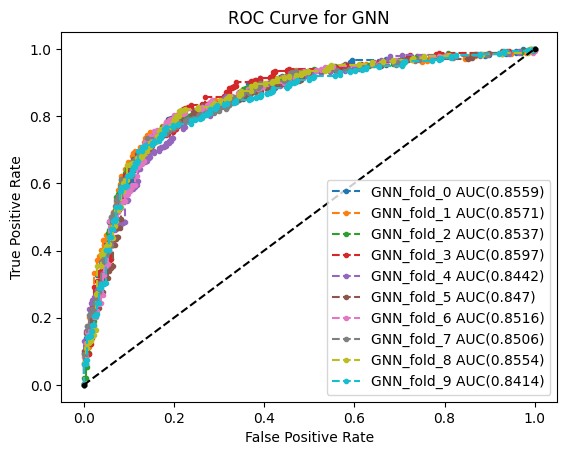

In [13]:
plot_ROC('GNN', total_performances_test)

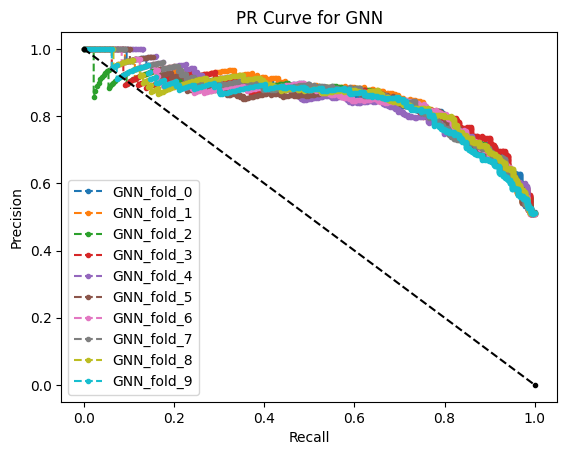

In [14]:
total_PR = total_performances_test[6]
plot_PR(total_data_pr=total_PR, method="GNN")

In [15]:
# Performance using training data
#=============================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model = list_modelA

for i,combined_model in enumerate(list_trained_model):  
    list_pred, list_targets = test_2(list_data_graph_train[i], combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_train = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_train[1] , total_performances_train[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

0.886215

In [16]:
perf = total_performances_train
model_title = 'Train Perf. hybrid model'
data_type ='graph-struct'
Create_Tables(perf, model_title, data_type)

+--------------------------+--------------+-------+------+-------+-------+-------+---------+---------+-----------+
|        Model Name        |  Data Type   | m_ACC | m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+--------------------------+--------------+-------+------+-------+-------+-------+---------+---------+-----------+
| Train Perf. hybrid model | graph-struct | 0.886 | 0.88 | 0.893 | 0.773 | 0.957 |  0.772  |  0.957  |   0.886   |
+--------------------------+--------------+-------+------+-------+-------+-------+---------+---------+-----------+
+--------------------------+--------------+-------+-------+------+-------+-------+---------+---------+-----------+
|        Model Name        |  Data Type   | e_ACC |  e_SN |  SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+--------------------------+--------------+-------+-------+------+-------+-------+---------+---------+-----------+
| Train Perf. hybrid model | graph-struct | 0.003 | 0.013 | 0.01 | 0.005 | 0.001

In [17]:
# Performance using training data
#=============================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model = list_modelA

for i, combined_model in enumerate(list_trained_model):  
    list_pred, list_targets = test_2(list_data_graph_val[i], combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)

# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_val = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_val[1] , total_performances_val[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

0.7580450000000001

In [18]:
perf = total_performances_val
model_title = 'Val. Perf. hybrid model'
data_type ='graph-struct'
Create_Tables(perf, model_title, data_type)

+-------------------------+--------------+-------+-------+------+-------+-------+---------+---------+-----------+
|        Model Name       |  Data Type   | m_ACC |  m_SN | m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+-------------------------+--------------+-------+-------+------+-------+-------+---------+---------+-----------+
| Val. Perf. hybrid model | graph-struct | 0.758 | 0.746 | 0.77 | 0.517 | 0.831 |  0.516  |  0.831  |   0.758   |
+-------------------------+--------------+-------+-------+------+-------+-------+---------+---------+-----------+
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |  Data Type   | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+-------------------------+--------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Val. Perf. hybrid model | graph-struct | 0.016 | 0.035 | 0.024 | 0.031 | 0.012 |  0